In my thesis project, I generated dozens of terabytes of mouse brain section image. In these images, there are fluorscence labeled neurons and synapses. I need extract all these fluorescence labeled synapse signals. After setting a threshold for intensity, not only fluorescent labeled axons, but also some artifacts were extracted from images. Currently,I just simply choose the region of interest (ROI) to select the area containing fluorescence labeled . This is a little time consuming and requires me to carefull go through every part of the brain sections. So, I was curious whether it is possible to use convolutional neural network to do this job, after I took the deep learning coursera course. 

First step. Load all related packages.

This is whole brain section view


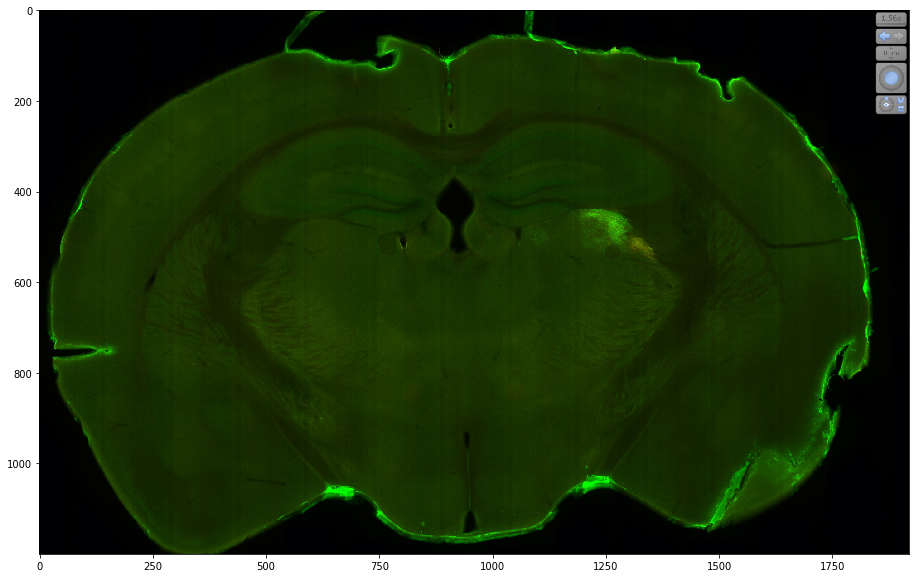

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
img = mpimg.imread('C:/Users/Anjin/whole brain view.png')
print('This is whole brain section view')
plt.imshow(img, cmap="gray")
plt.show()


This is a zoom-in view of synapses


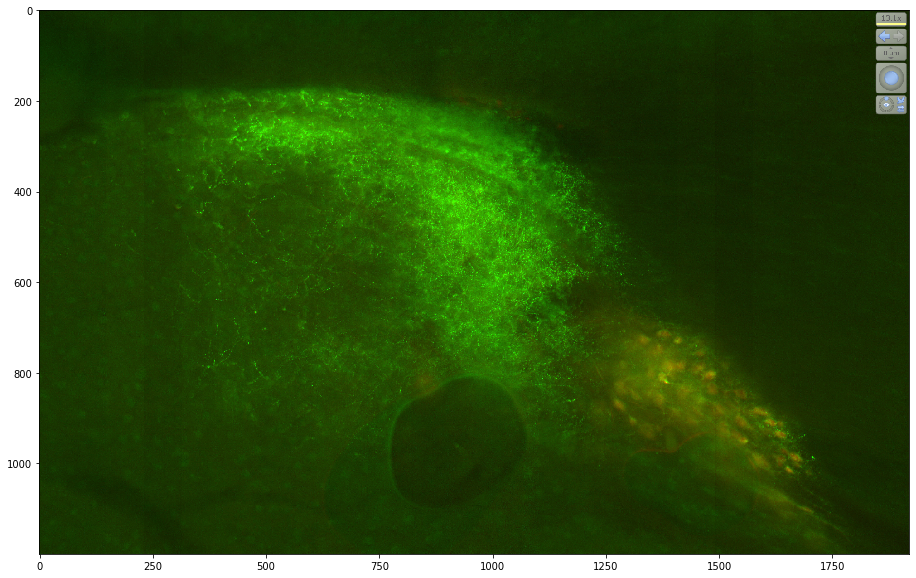

In [3]:
plt.rcParams["figure.figsize"] = (20,10)
img = mpimg.imread('C:/Users/Anjin/synapse.png')
print('This is a zoom-in view of synapses')
plt.imshow(img, cmap="gray")
plt.show()


There are artifact in the images


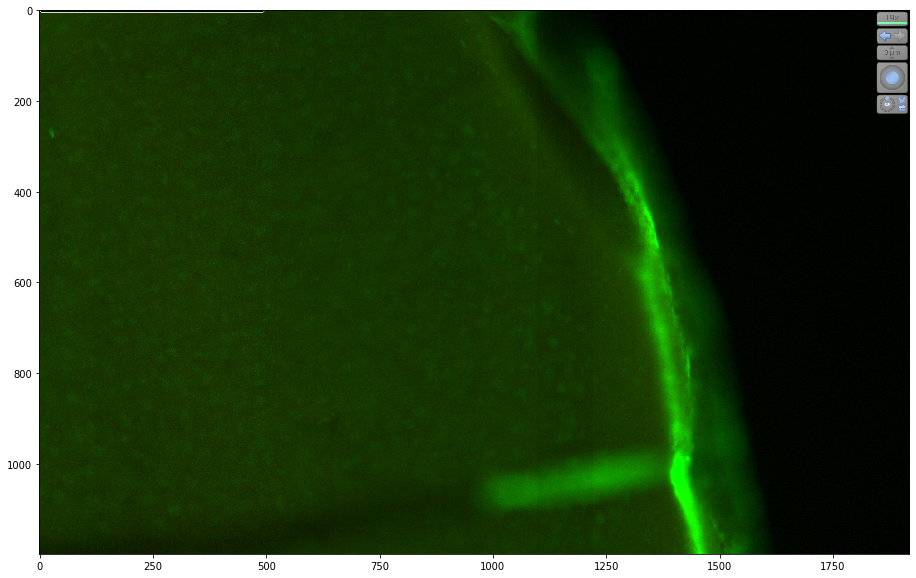

In [6]:
img = mpimg.imread('C:/Users/Anjin/artifact.png')
print('There are artifact in the images')
plt.imshow(img, cmap="gray")
plt.show()

In [7]:
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D,Conv3D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D,MaxPooling3D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
 
%matplotlib inline

Data preparation: I wrote a MATLAB script to extract image tiles containing fluorescence labeled synapses in ROI and the image tiles containing artifacts. Since I collected 7 focal layers for each brain sections, I used the volume of inner 4 focal layers.

In [28]:
import numpy as np
import os as os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

images = []
folder = 'C:/Users/Anjin/signal/'
for filename in os.listdir(folder):
    try:
        img = mpimg.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    except:
        print('Cant import ' + filename)
images = np.asarray(images)
images.shape

(1072, 400, 400)

Here is one example containing synapse signals. The four tiles are 4 focal layers.

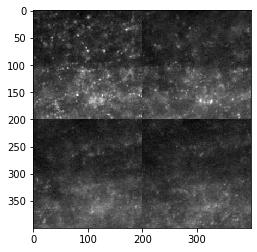

In [34]:
from matplotlib import pyplot as plt
plt.imshow(images[1,:,:], cmap="gray")
plt.show()

Here is an example which the upper two focal layers are out focus. The bottom two layers have a little bit signals

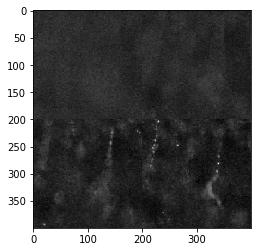

In [33]:
plt.imshow(images[10,:,:], cmap="gray")
plt.show()

In [ ]:
Reshape the images into 4 dimensions.

In [9]:
signal=np.zeros((images.shape[0],200,200,4))
for zlayer in range(3):
    for m in range(images.shape[0]):
     if zlayer==0:
        signal[m,:,:,zlayer]=images[m,0:200,0:200]
     elif zlayer==1:
        signal[m,:,:,zlayer]=images[m,0:200,200:400]
     elif zlayer==2:
        signal[m,:,:,zlayer]=images[m,200:400,0:200]
     elif zlayer==3:
        signal[m,:,:,zlayer]=images[m,200:400,200:400]
signal.shape        

(1072, 200, 200, 4)

In [37]:
import numpy as np
import os as os
import matplotlib.image as mpimg

images = []
folder = 'C:/Users/Anjin/noise/'
for filename in os.listdir(folder):
    try:
        img = mpimg.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    except:
        print('Cant import ' + filename)
images = np.asarray(images)


Here is an example of image containg hyperbright artifact.

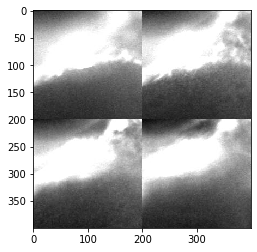

In [39]:
plt.imshow(images[1,:,:], cmap="gray")
plt.show()

Here is another example which has overstaining on the cell bodies

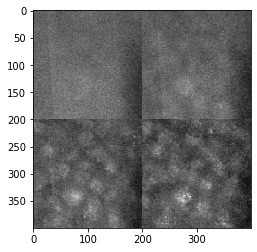

In [45]:
plt.imshow(images[120,:,:], cmap="gray")
plt.show()

Reshape noise images into 4 dimensions

In [ ]:
noise=np.zeros((images.shape[0],200,200,4))
for zlayer in range(3):
    for m in range(images.shape[0]):
     if zlayer==0:
        noise[m,:,:,zlayer]=images[m,0:200,0:200]
     elif zlayer==1:
        noise[m,:,:,zlayer]=images[m,0:200,200:400]
     elif zlayer==2:
        noise[m,:,:,zlayer]=images[m,200:400,0:200]
     elif zlayer==3:
        noise[m,:,:,zlayer]=images[m,200:400,200:400]
noise.shape     

Import all libraries for keras deep learning

In [469]:
import math
import numpy as np
import h5py
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from sklearn.model_selection import train_test_split


%matplotlib inline
np.random.seed(1)

Generate the training, validation and test set

In [470]:
X=np.concatenate((signal, noise), axis=0)
##generate label
Y=np.concatenate((np.ones([signal.shape[0],1]),np.zeros([noise.shape[0],1])), axis=0)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)
print(X.shape)
print(Y.shape)

(2432, 200, 200, 4)
(2432, 1)


The model I used here have been tweaked mutiple times. Somehow the batch normalization does not work in keras, so I removed it. The 95% validation accuracy is the best I can get. After testing with the test set, I got 95% accuracy. Considering there is not much overfitting, I have tried to increase the model complexity. However, the training time increases. I could try to use a GPU to train in the next time.

In [367]:
def classifier2(input_shape):
    X_input = Input(input_shape)
    X = Conv2D(filters=16, kernel_size=(4, 4), strides = (1, 1), padding='same', name = 'conv0')(X_input)
    #X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('sigmoid')(X)  
    X = MaxPooling2D(pool_size=(8, 8), name='max_pool0')(X)   
    X = Conv2D(filters=16, kernel_size=(2, 2), strides = (1, 1), padding='same', name = 'conv1')(X)
    #X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X = Activation('sigmoid')(X)  
    X = MaxPooling2D(pool_size=(4, 4), name='max_pool1')(X)   
    X = Flatten()(X)
    X = Dense(units=1, activation='sigmoid', name='fc')(X) 
    model = Model(inputs = X_input, outputs = X, name='HappyModel')
    return model

In [442]:
from keras import regularizers
Classifier2 = classifier2((200, 200, 4))
Classifier2.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [488]:
Classifier2.fit(x = X_train, y = Y_train, epochs = 1, batch_size = 128,validation_data=(X_val,Y_val))#

Train on 1629 samples, validate on 401 samples
Epoch 1/1
1629/1629 [==============================] - 19s 11ms/step - loss: 0.1222 - acc: 0.9509 - val_loss: 0.1546 - val_acc: 0.9476


In [489]:
preds = Classifier2.evaluate(x = X_test, y = Y_test,batch_size=128)
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

402/402 [==============================] - 1s 3ms/step

Loss = 0.12644269995724977
Test Accuracy = 0.9527363172217981


In [493]:
pred = Classifier2.predict(x=X_test)
pred2=pred

In [494]:
pred[pred<0.5]=0
pred[pred>=0.5]=1
print(sum(abs(pred-Y_test)==0)/len(Y_test))

[0.95273632]


Here I extracted all images with wrong classification.

In [495]:
num,_=np.where(abs(pred-Y_test)==1)
num

array([ 16,  33,  37,  61,  69,  97, 102, 139, 149, 162, 163, 171, 177,
       183, 194, 219, 221, 281, 385], dtype=int64)

Here is an example with wrong classification. I took one layer out of the 4 layer images. It is supposed to be a image containing the noise. The model thinks it contains signals. It is a hard one. Without zooming out to look at the other part of brain, it is even difficult for me to judge. 

[0.]


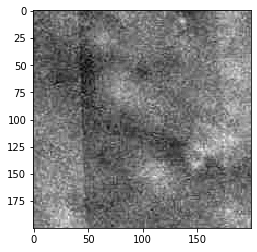

In [499]:
num1=61
plt.gray()
plt.imshow(X_test[num1,:,:,1])
print(Y_test[num1])


Conclusion: 95% accuracy is not very useful. One solution could be considering the nearby tiles on the brain sections. Since synapses mostly should be clustered together, there should not be a single tile being different from all nearby tiles. By viewing the identities of all tiles on the brain section, manual correction can be done for those outliers.I will try this method if I have the time. This is all for now.